In [28]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ml-talentmatch/df.pickle


In [29]:
# PATH = '..'
# DATA_SOURCE = f'{PATH}/data/source'
# DATA_PROCESSED = f'{PATH}/data/processed'
# DATA_MODELS = f'{PATH}/models'

DATA_PROCESSED = f'/kaggle/input/ml-talentmatch'
DATA_MODELS = f''

SEED = 42
DEVICE = 'cuda'
n_pos, n_neg = 4, 4
MAX_LEN = 512
model_name = 'cointegrated/rubert-tiny2'

In [30]:
import pandas as pd
import os
from sklearn.model_selection import train_test_split

from transformers import AutoTokenizer, AutoModel
import torch
from torch.utils.data import DataLoader, Dataset
import numpy as np
import pandas as pd
import os
import random

import torch
from torch import nn, Tensor
from typing import Iterable, Dict


from tqdm.notebook import tqdm
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline, make_pipeline, make_union
from transformers.optimization import AdamW, get_linear_schedule_with_warmup
from torch.optim import AdamW
from matplotlib import pyplot as plt
from sklearn.metrics import roc_auc_score

from IPython.display import clear_output
import gc
from pathlib import Path

from transformers import AutoModelForSequenceClassification
from torch.nn import CrossEntropyLoss

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

import seaborn as sns

from sklearn.metrics import roc_auc_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.metrics import precision_score

import warnings
warnings.filterwarnings("ignore", category=UserWarning) 

In [31]:
def clear_cache():
    gc.collect()
    torch.cuda.empty_cache()

In [32]:
def plot_hist(df, label_col, proba_col):
    sns.distplot(df.query(f'{label_col} == 0')[proba_col], bins=50, label='label 0')
    sns.distplot(df.query(f'{label_col} == 1')[proba_col], bins=50, label='label 1')
    plt.legend()
    plt.show()
    
def print_metrics(df, group_col, label_col, proba_col, tr):
    scores = df \
        .groupby(group_col)[[label_col, proba_col]] \
        .agg(list) \
        .apply(lambda x: pd.Series({
            'roc_auc_score': (roc_auc_score(x.iloc[0], x.iloc[1])), 
            'f1_score': (f1_score(x.iloc[0], np.array(x.iloc[1]) > tr)),
            'precision_score': (precision_score(x.iloc[0], np.array(x.iloc[1]) > tr)),
            'recall_score': (recall_score(x.iloc[0], np.array(x.iloc[1]) > tr)),
        }), axis=1)
    display(scores)
    display(scores.mean())
    
def calc_metrics(df, group_col, label_col, proba_col, tr):
    scores = df \
        .groupby(group_col)[[label_col, proba_col]] \
        .agg(list) \
        .apply(lambda x: pd.Series({
            'roc_auc_score': (roc_auc_score(x.iloc[0], x.iloc[1])), 
            'f1_score': (f1_score(x.iloc[0], np.array(x.iloc[1]) > tr)),
            'precision_score': (precision_score(x.iloc[0], np.array(x.iloc[1]) > tr)),
            'recall_score': (recall_score(x.iloc[0], np.array(x.iloc[1]) > tr)),
        }), axis=1)
    return scores

In [33]:
def seed_all(seed_value):
    random.seed(seed_value)
    np.random.seed(seed_value)
    torch.manual_seed(seed_value)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value)
        torch.backends.cudnn.benchmark = True
        torch.backends.cudnn.deterministic = False


In [34]:
class TextDataset(Dataset):
    def __init__(self, tokenizer, query, document, relevance=None, cluster=None, max_length=128):
        self.len = len(query)
        self.query = tokenizer.batch_encode_plus(
            list(query), 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=max_length
        )
        self.document = tokenizer.batch_encode_plus(
            list(document), 
            padding=True, 
            truncation=True, 
            return_tensors='pt', 
            max_length=max_length
        )        
        if relevance is not None:
            self.relevance = torch.tensor(list(relevance))
        else:
            self.relevance = torch.tensor(np.ones(len(query)))
        if cluster is not None:
            self.cluster = torch.tensor(list(cluster))
        else:
            self.cluster = torch.tensor(np.ones(len(query)))

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        query = dict(
            input_ids=self.query['input_ids'][idx],
            attention_mask=self.query['attention_mask'][idx],
        )
        document = dict(
            input_ids=self.document['input_ids'][idx],
            attention_mask=self.document['attention_mask'][idx],
        )
        relevance = self.relevance[idx]        
        return dict(
            query = query,
            document = document,
            relevance = relevance,
        )

In [35]:
class ModelCheckpoint:
    """Save the model after every epoch.
    `filepath` can contain named formatting options,
    which will be filled the value of `epoch` and `val_loss`.
    For example: if `filepath` is `weights.{epoch:02d}-{val_loss:.2f}.hdf5`,
    then the model checkpoints will be saved with the epoch number and
    the validation loss in the filename.
    # Arguments
        model: PyTorch model object
        filepath: string, path to save the model file.
        save_best_only: if `save_best_only=True`,
            the latest best model according to
            the quantity monitored will not be overwritten.
        mode: one of {min, max}.
            If `save_best_only=True`, the decision
            to overwrite the current save file is made
            based on either the maximization or the
            minimization of the monitored quantity. For `val_acc`,
            this should be `max`, for `val_loss` this should
            be `min`, etc.
        save_weights_only: if True, then only the model's weights will be
            saved, else the full model is saved.
    """

    def __init__(
        self,
        model: torch.nn.Module,
        filepath: str,
        mode: str = "min",
        save_best_only: bool = True,
        save_weights_only: bool = False,
    ):
        self.model = model
        self.filepath = filepath
        self.mode = mode
        self.save_best_only = save_best_only
        self.save_weights_only = save_weights_only
        self.num_saves = 0

        if mode == "min":
            self.monitor_op = np.less
            self.best = np.Inf
        elif mode == "max":
            self.monitor_op = np.greater
            self.best = -np.Inf
        else:
            raise ValueError("mode " + mode + " is unknown!")

        Path(self.filepath).parent.mkdir(exist_ok=True, parents=True)

    def _save_model(self):
        if self.save_weights_only:
            torch.save(self.model.state_dict(), self.filepath)
        else:
            torch.save(self.model, self.filepath)
        self.num_saves += 1

    def step(self, current, epoch=None):
        if isinstance(current, torch.Tensor):
            current = current.cpu()
        if self.save_best_only:
            if self.monitor_op(current, self.best):
                self.best = current
                self._save_model()
        else:
            self._save_model()

In [36]:
import torch
import torch.nn as nn
from transformers import BertModel

class MeanPooling(nn.Module):
    def __init__(self):
        super(MeanPooling, self).__init__()
        
    def forward(self, last_hidden_state, attention_mask):
        input_mask_expanded = attention_mask.unsqueeze(-1).expand(last_hidden_state.size()).float()
        sum_embeddings = torch.sum(last_hidden_state * input_mask_expanded, 1)
        sum_mask = input_mask_expanded.sum(1)
        sum_mask = torch.clamp(sum_mask, min = 1e-9)
        mean_embeddings = sum_embeddings/sum_mask
        return mean_embeddings

class ColBERT(nn.Module):
    def __init__(self, bert, dim=768, add_pooling=False):
        super(ColBERT, self).__init__()
        self.bert = bert
        self.fc = nn.Linear(dim*2**add_pooling, 1)
        self.sigmoid = nn.Sigmoid()
        self.pooling = MeanPooling()
        self.add_pooling = add_pooling
        # self.fc = nn.Sequential(
        #     nn.Linear(dim*(2**add_pooling), dim*(2**add_pooling)),
        #     nn.LayerNorm(dim*2**add_pooling),
        #     nn.GELU(),
        #     nn.Linear(dim*2**add_pooling, 1),
        # )
        
    def forward(self, query, document):
        query_embedding = self.bert(**query)[0][:, 0, :]
        document_embedding = self.bert(**document)[0][:, 0, :]
        interaction = torch.mul(query_embedding, document_embedding)
        
        if self.add_pooling:
            output = self.bert(**document)
            pooling = self.pooling(output['last_hidden_state'], document['attention_mask'])
            emb = torch.cat((interaction,pooling), -1)
        else:
            emb = interaction
        scores = self.fc(emb)
        relevance_scores = self.sigmoid(scores).squeeze()
        return relevance_scores

In [10]:
def batch_generator(sentences, batch_size):
    n_samples = len(sentences)
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        yield sentences[start:end]

In [11]:
def batch_generator_random(dataset, n_pos, n_neg):
    df = pd.DataFrame(zip(
        dataset.relevance.cpu().numpy(), 
        dataset.cluster.cpu().numpy()
    ), columns=['relevance', 'cluster'])
    
    df['idx'] = range(len(df))
    ids = []
    for id_cluster, subset_cluster in df.groupby('cluster'):
        mask_positive = subset_cluster['relevance'] == 1
        mask_negative = subset_cluster['relevance'] == 0
        ids.append(np.concatenate([
            subset_cluster[mask_positive].sample(min(n_pos, mask_positive.sum()))['idx'].values,
            subset_cluster[mask_negative].sample(min(n_neg, mask_negative.sum()))['idx'].values,
        ]))
    ids = np.concatenate(ids)
    return dataset[ids]

In [12]:
seed_all(SEED)

# Модель

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_name)
bert = AutoModel.from_pretrained(model_name)

model = ColBERT(bert, 312)
model.to(DEVICE)

model_checkpoint = ModelCheckpoint(model, f'{DATA_MODELS}/{model_name.split("/")[-1]}.pt', mode="max")

df = pd.read_pickle(f'{DATA_PROCESSED}/df.pickle')

# убираем всех java разработчиков из трейна
# mask = df.eval('id_cluster == 1 and split == "train"')
# df.loc[mask, 'split'] = 'val_2'


mask_train = df['split'] == 'train'
mask_val = df['split'] == 'val'
mask_test = df['split'] == 'test'

ds_train = TextDataset(
    tokenizer, 
    query=df.loc[mask_train, 'description_sorted_vacancy'], 
    document=df.loc[mask_train, 'description_sorted_resume'], 
    relevance=df.loc[mask_train, 'label'], 
    cluster=df.loc[mask_train, 'id_cluster'], 
    max_length=MAX_LEN
)

ds_val = TextDataset(
    tokenizer, 
    query=df.loc[mask_val, 'description_sorted_vacancy'], 
    document=df.loc[mask_val, 'description_sorted_resume'], 
    relevance=df.loc[mask_val, 'label'], 
    max_length=MAX_LEN
)

ds_test = TextDataset(
    tokenizer, 
    query=df.loc[mask_test, 'description_sorted_vacancy'], 
    document=df.loc[mask_test, 'description_sorted_resume'], 
    max_length=MAX_LEN
)

In [14]:
n_clusters = df['id_cluster'].nunique()
(n_pos + n_neg) * n_clusters

80

In [15]:
lr = 0.0000125  # usually from 1e-5 until 8e-5
# warmup_steps = 50
# num_steps = 12000

optimizer = AdamW(
    [p for p in model.parameters() if p.requires_grad],
    lr=lr, weight_decay=0.01
)


# scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=warmup_steps, num_training_steps=num_steps)
loss_fn = nn.BCELoss()

# num_steps = 100000
# global_step = 0
tr_loss, logging_loss = 0.0, 0.0
gradient_accumulation_steps = 1
# batch_size = 8
max_grad_norm = 1
logging_steps = 1000  # периодичность проверки качества модели, чтобы во время остановить обучение

step=0
result = []

epoch: 0


,train,val
loss,0.000000,0.00000
roc_auc,0.481625,0.48669
f1,0.000000,0.00000
precision,0.000000,0.00000
recall,0.000000,0.00000


,roc_auc_score,f1_score,precision_score,recall_score
uuid_vacancy,,,,
4e2299c0-13fc-301d-8f3c-3ccfd0281ce6,0.444444,0.0,0.0,0.0
a5d0e1fd-7baa-3a6f-98f4-b908ac7fce43,0.500000,0.0,0.0,0.0
b2315867-73a2-3d43-acac-cbb92bd793b3,0.515625,0.0,0.0,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


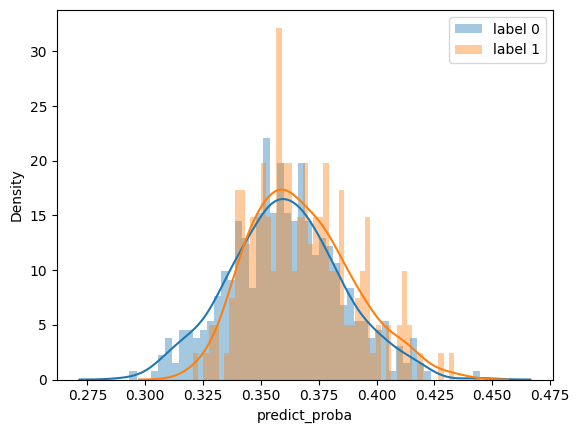

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


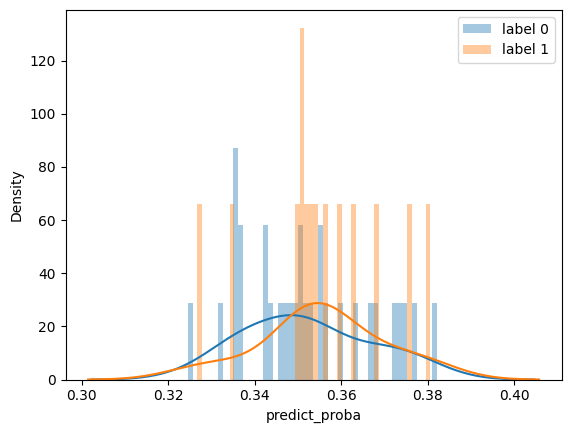

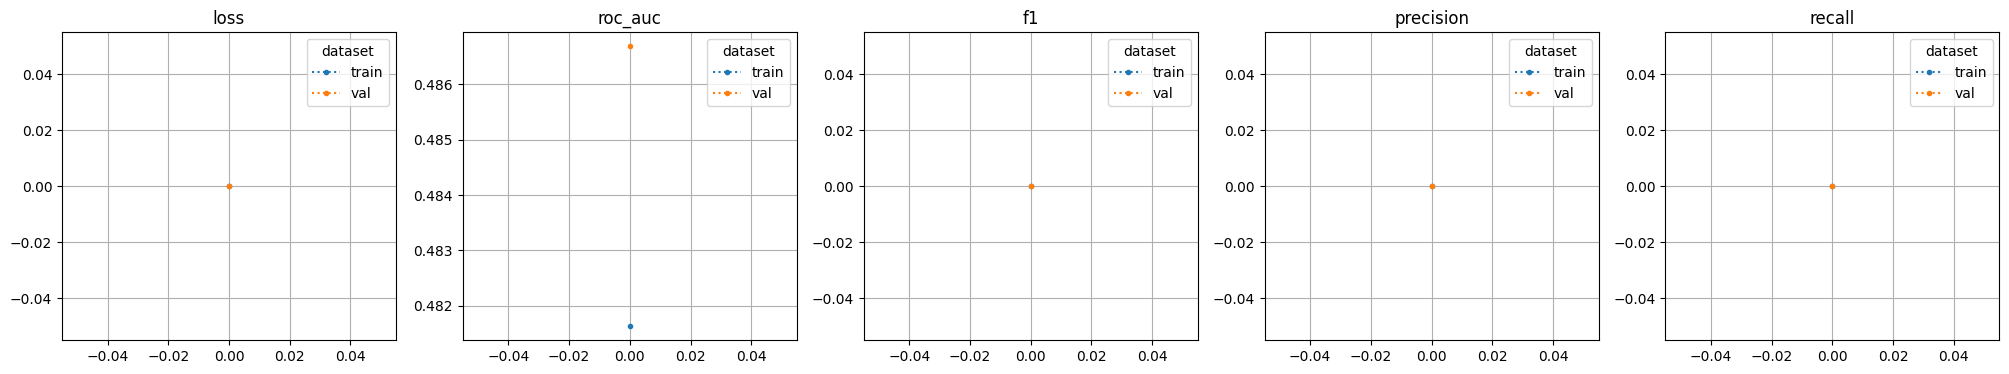

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 1


,train,val
loss,0.020505,0.000000
roc_auc,0.706767,0.646528
f1,0.408076,0.166667
precision,0.411586,0.125000
recall,0.517170,0.250000


,roc_auc_score,f1_score,precision_score,recall_score
uuid_vacancy,,,,
4e2299c0-13fc-301d-8f3c-3ccfd0281ce6,0.750000,0.5,0.375,0.75
a5d0e1fd-7baa-3a6f-98f4-b908ac7fce43,0.533333,0.0,0.000,0.00
b2315867-73a2-3d43-acac-cbb92bd793b3,0.656250,0.0,0.000,0.00


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


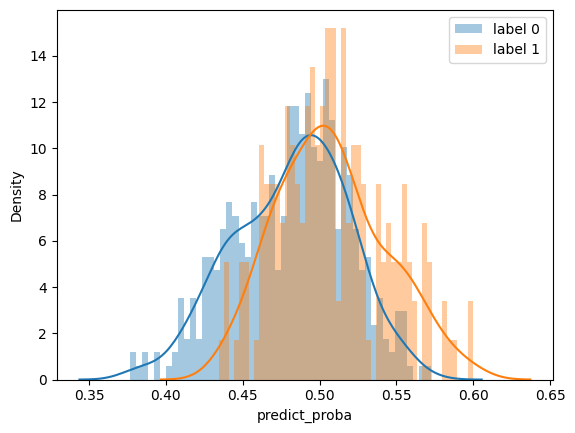

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


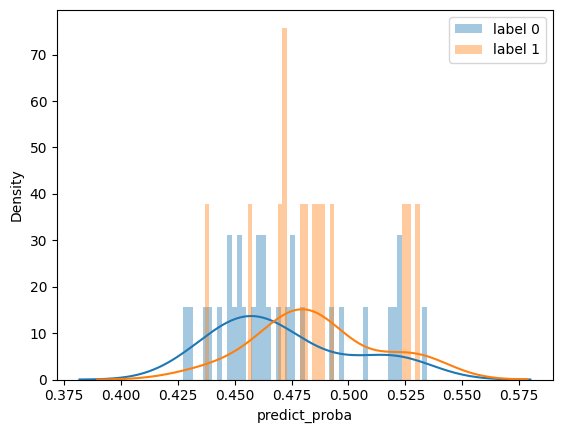

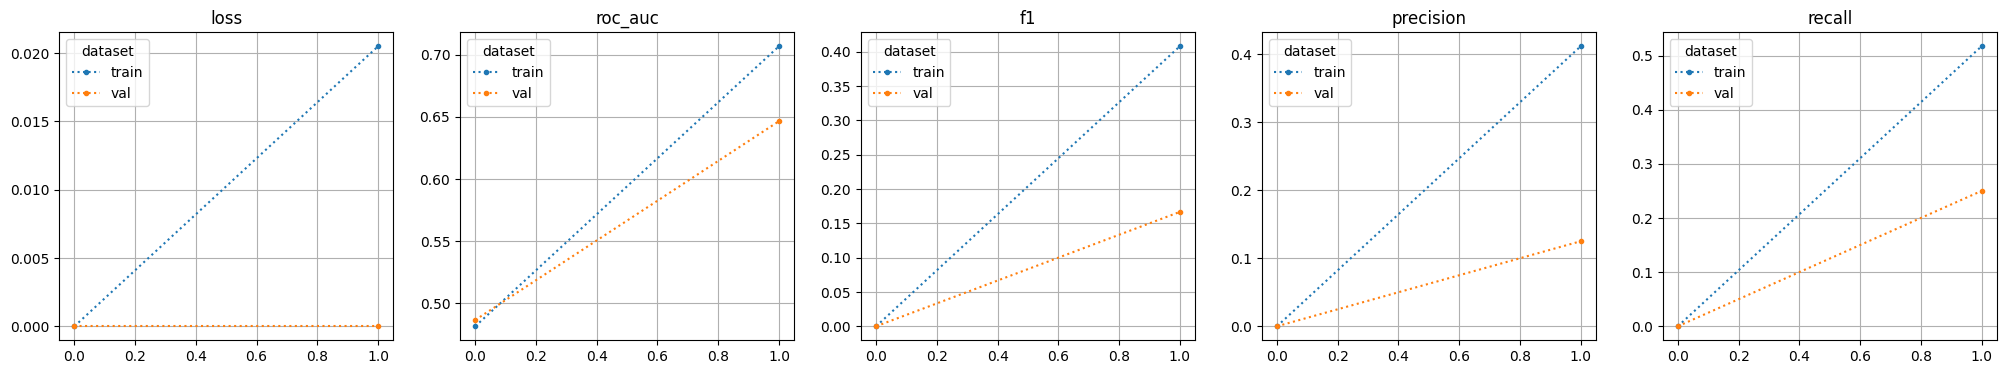

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 2


,train,val
loss,0.018451,0.000000
roc_auc,0.813129,0.681713
f1,0.543564,0.296296
precision,0.522405,0.277778
recall,0.653118,0.388889


,roc_auc_score,f1_score,precision_score,recall_score
uuid_vacancy,,,,
4e2299c0-13fc-301d-8f3c-3ccfd0281ce6,0.888889,0.666667,0.500000,1.000000
a5d0e1fd-7baa-3a6f-98f4-b908ac7fce43,0.500000,0.222222,0.333333,0.166667
b2315867-73a2-3d43-acac-cbb92bd793b3,0.656250,0.000000,0.000000,0.000000


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


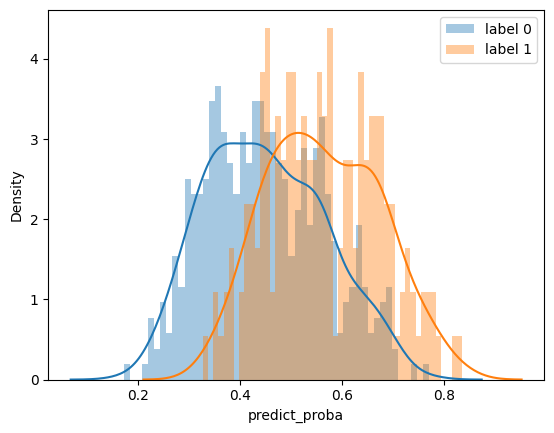

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


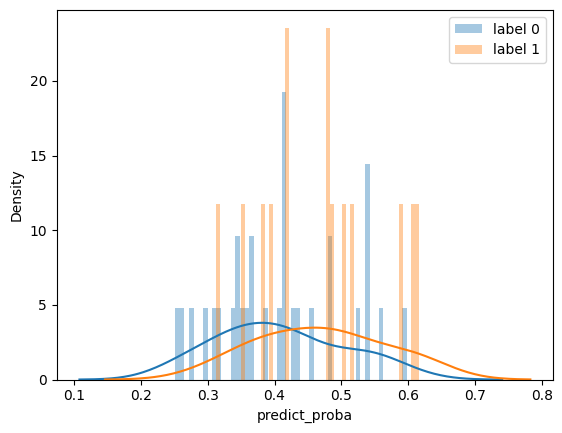

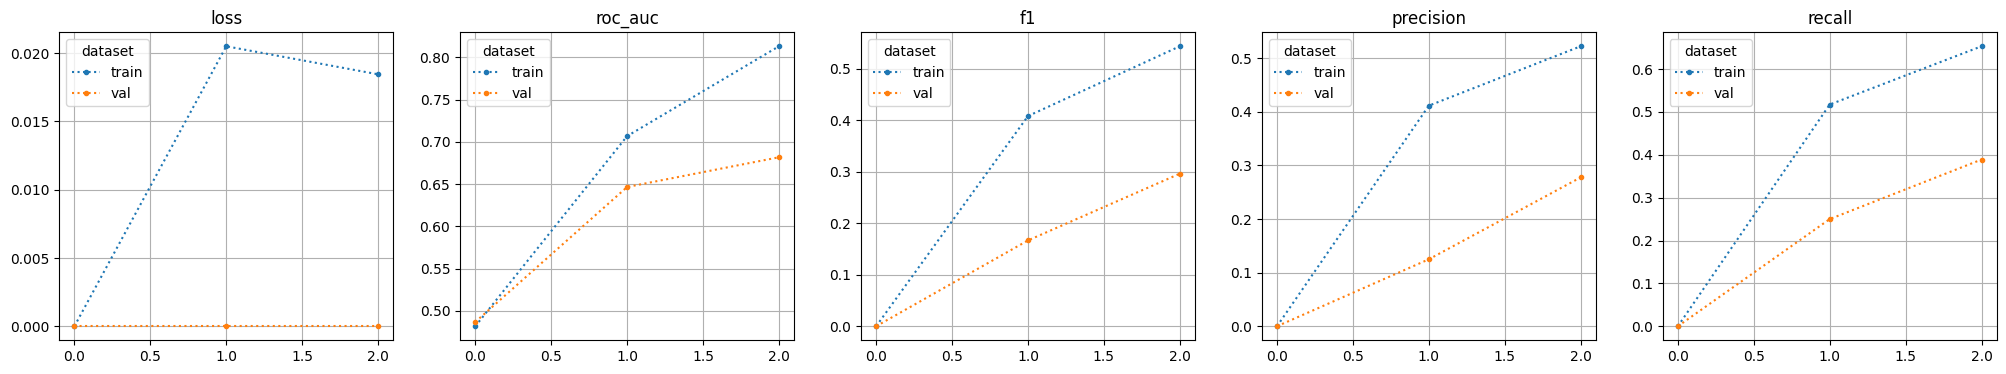

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 3


,train,val
loss,0.014333,0.000000
roc_auc,0.894815,0.695255
f1,0.718077,0.190476
precision,0.710568,0.222222
recall,0.796958,0.166667


,roc_auc_score,f1_score,precision_score,recall_score
uuid_vacancy,,,,
4e2299c0-13fc-301d-8f3c-3ccfd0281ce6,0.888889,0.571429,0.666667,0.5
a5d0e1fd-7baa-3a6f-98f4-b908ac7fce43,0.400000,0.000000,0.000000,0.0
b2315867-73a2-3d43-acac-cbb92bd793b3,0.796875,0.000000,0.000000,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


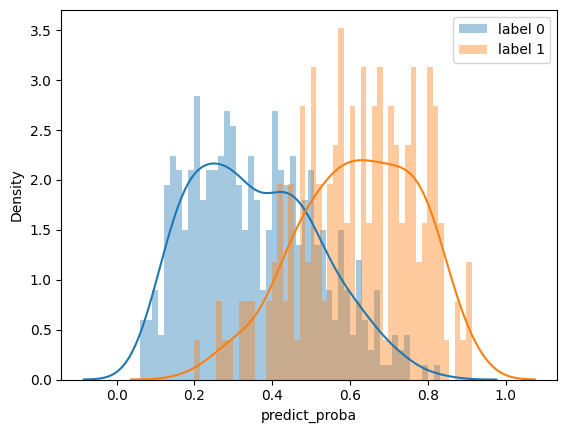

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


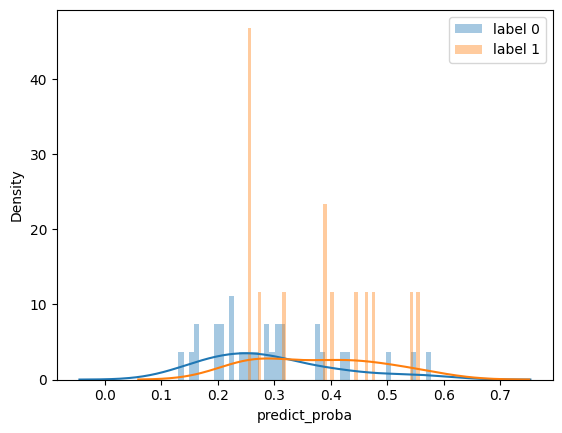

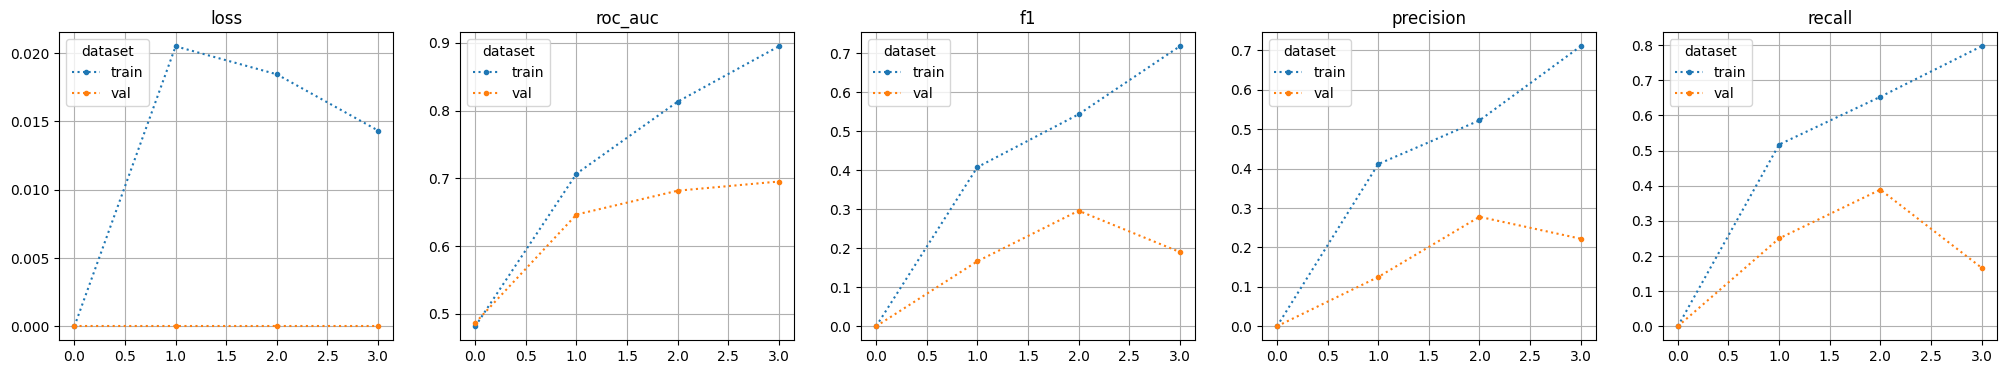

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 4


,train,val
loss,0.009453,0.000000
roc_auc,0.947212,0.706481
f1,0.821665,0.000000
precision,0.807240,0.000000
recall,0.897879,0.000000


,roc_auc_score,f1_score,precision_score,recall_score
uuid_vacancy,,,,
4e2299c0-13fc-301d-8f3c-3ccfd0281ce6,0.777778,0.0,0.0,0.0
a5d0e1fd-7baa-3a6f-98f4-b908ac7fce43,0.466667,0.0,0.0,0.0
b2315867-73a2-3d43-acac-cbb92bd793b3,0.875000,0.0,0.0,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


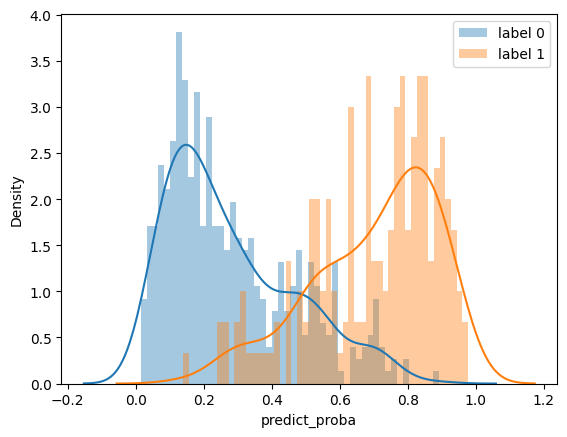

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


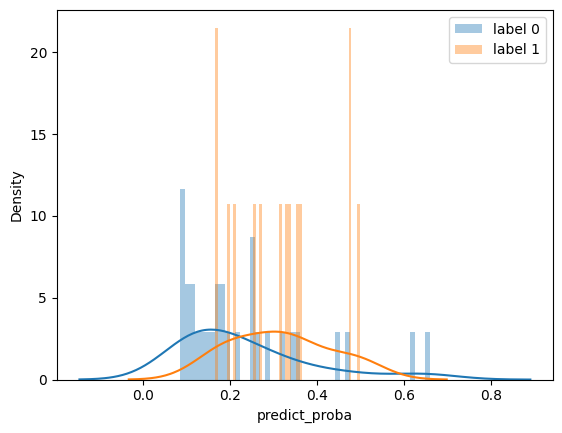

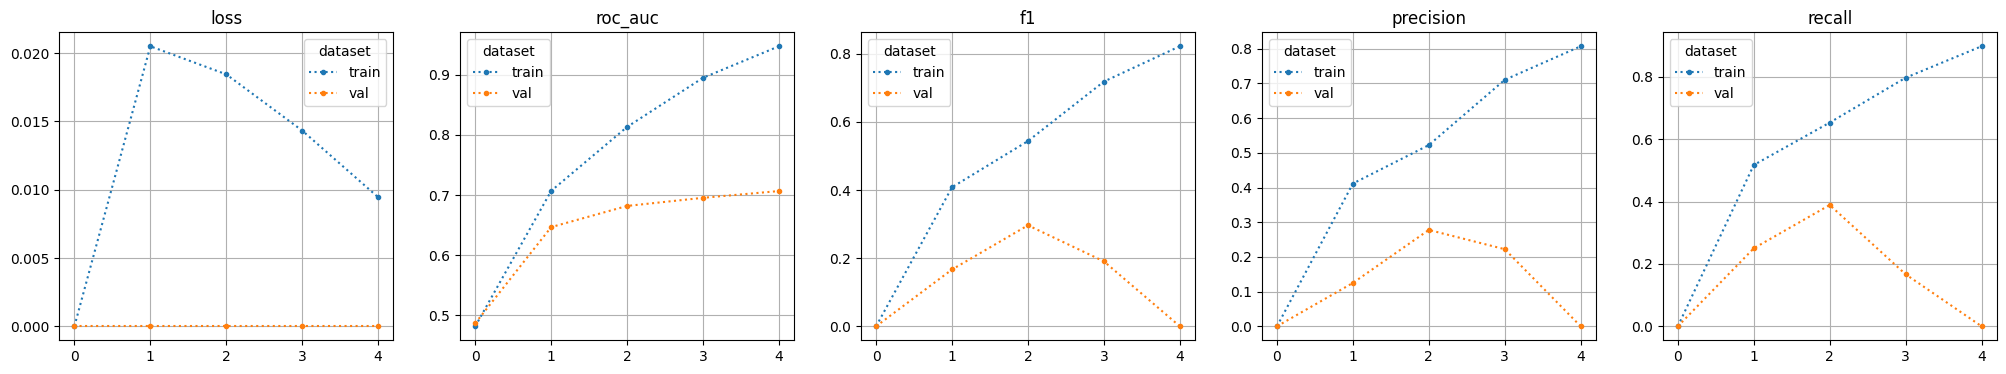

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 5


,train,val
loss,0.006022,0.000000
roc_auc,0.972965,0.646065
f1,0.860617,0.000000
precision,0.824595,0.000000
recall,0.940117,0.000000


,roc_auc_score,f1_score,precision_score,recall_score
uuid_vacancy,,,,
4e2299c0-13fc-301d-8f3c-3ccfd0281ce6,0.694444,0.0,0.0,0.0
a5d0e1fd-7baa-3a6f-98f4-b908ac7fce43,0.400000,0.0,0.0,0.0
b2315867-73a2-3d43-acac-cbb92bd793b3,0.843750,0.0,0.0,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


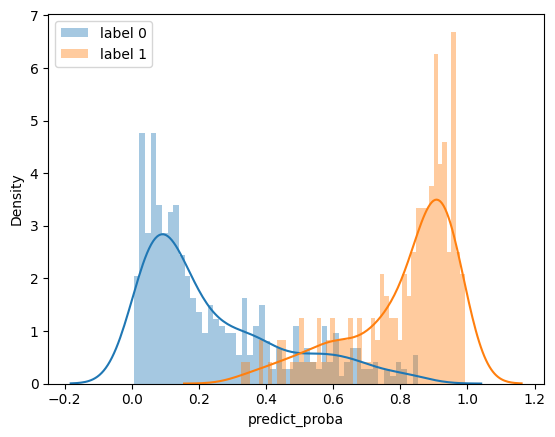

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


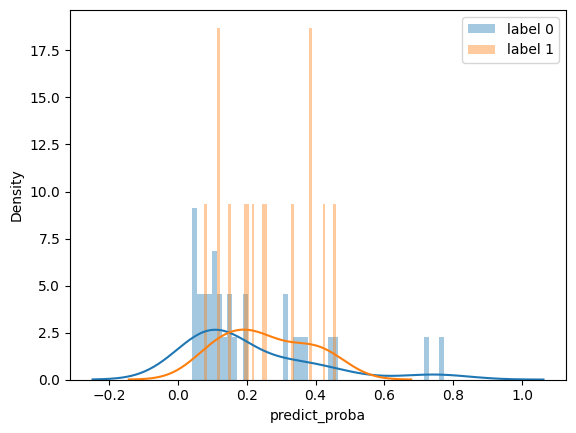

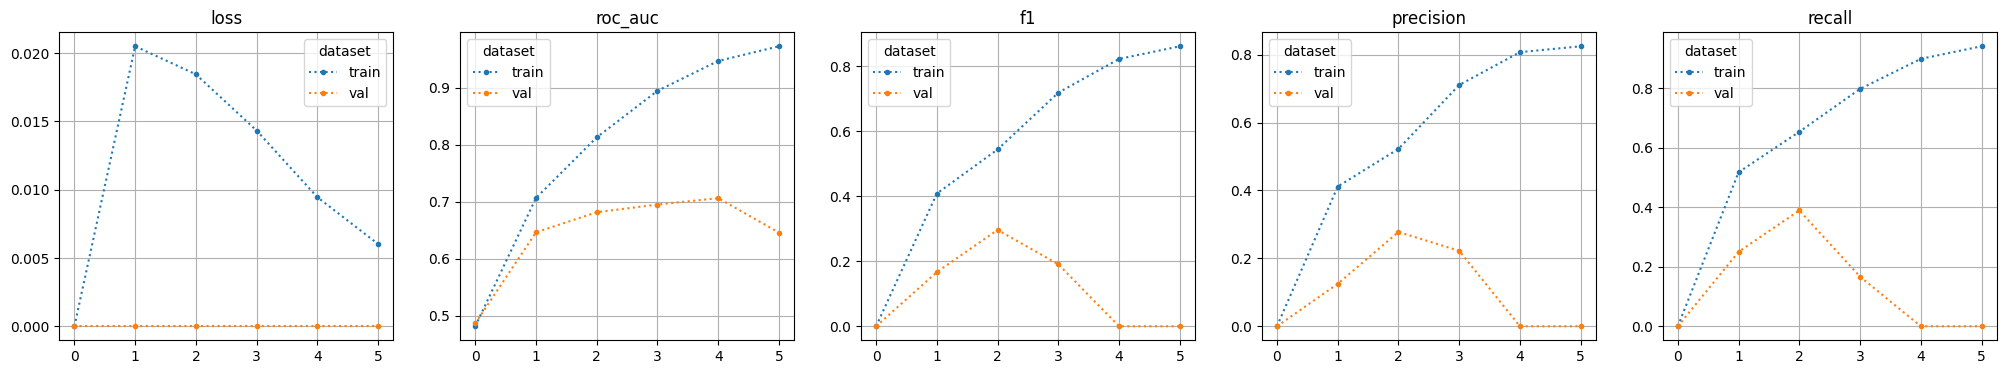

  0%|          | 0/30 [00:00<?, ?it/s]

epoch: 6


,train,val
loss,0.004172,0.00000
roc_auc,0.991955,0.61412
f1,0.910576,0.00000
precision,0.882675,0.00000
recall,0.968540,0.00000


,roc_auc_score,f1_score,precision_score,recall_score
uuid_vacancy,,,,
4e2299c0-13fc-301d-8f3c-3ccfd0281ce6,0.694444,0.0,0.0,0.0
a5d0e1fd-7baa-3a6f-98f4-b908ac7fce43,0.366667,0.0,0.0,0.0
b2315867-73a2-3d43-acac-cbb92bd793b3,0.781250,0.0,0.0,0.0


/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


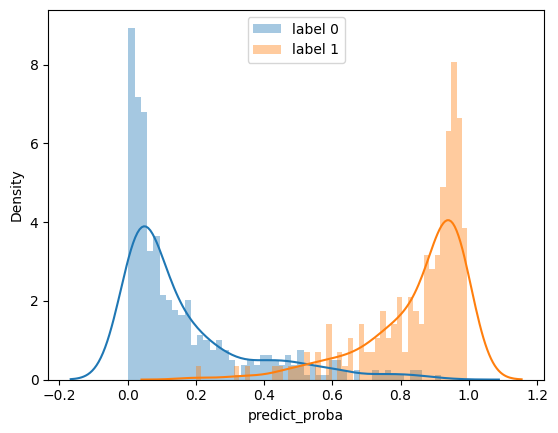

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


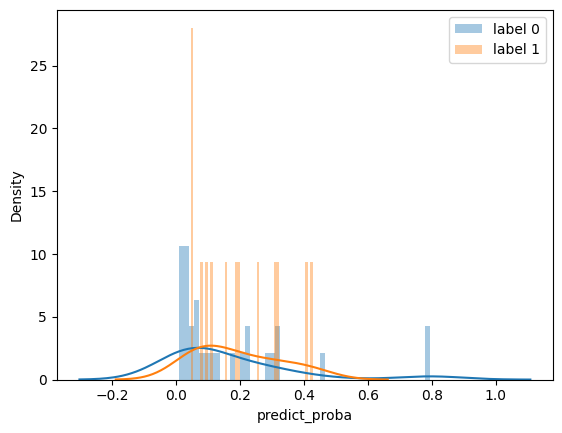

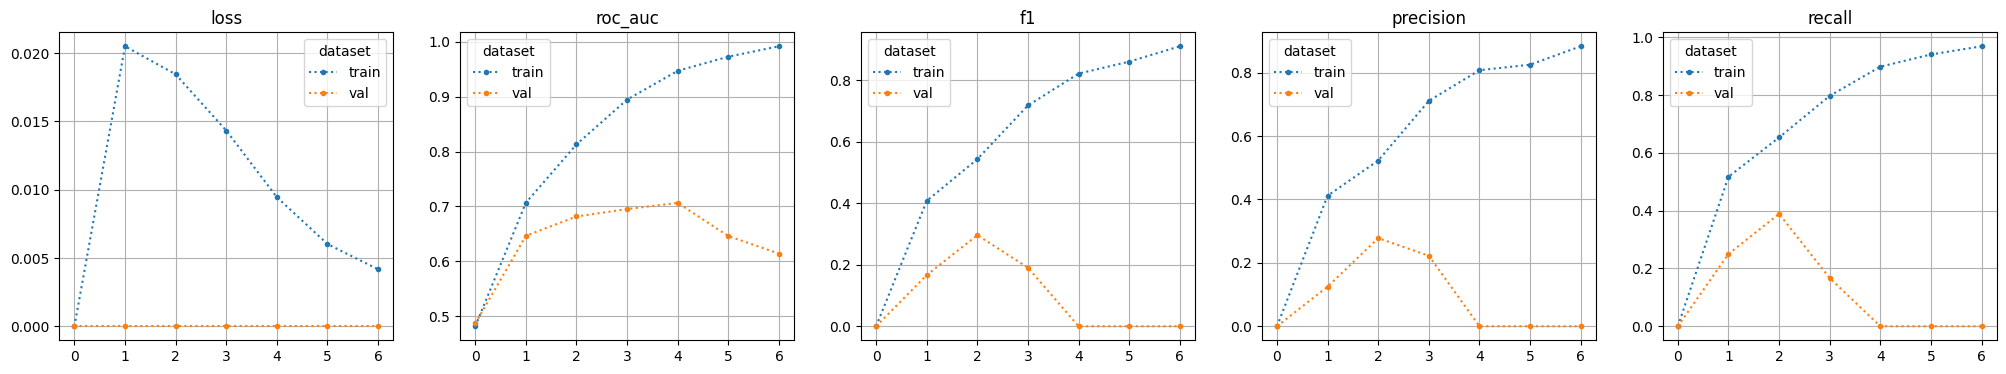

  0%|          | 0/30 [00:00<?, ?it/s]

In [16]:
for stepp in range(7):
    print('epoch:', stepp)
    # проверка качества
    model.eval()
    with torch.no_grad():
        # clear_output()

        # val
        with torch.no_grad():
            df.loc[mask_train, 'predict_proba'] = np.concatenate([
                model(
                    {k: v.to(DEVICE) for k, v in batch['query'].items()}, 
                    {k: v.to(DEVICE) for k, v in batch['document'].items()}
                ).cpu().numpy().squeeze() 
                for batch in batch_generator(ds_train, 10)
            ])

        with torch.no_grad():
            df.loc[mask_val, 'predict_proba'] = np.concatenate([
                model(
                    {k: v.to(DEVICE) for k, v in batch['query'].items()}, 
                    {k: v.to(DEVICE) for k, v in batch['document'].items()}
                ).cpu().numpy().squeeze() 
                for batch in batch_generator(ds_val, 10)
            ])
        train_score = calc_metrics(df.query('split == "train"'), 'uuid_vacancy', 'label', 'predict_proba', 0.5)
        val_score = calc_metrics(df.query('split == "val"'), 'uuid_vacancy', 'label', 'predict_proba', 0.5)

        # add result
        result.append(dict(
            train = dict(
                loss = tr_loss if step == 0 else (tr_loss - logging_loss) / logging_steps,
                roc_auc = train_score.mean()['roc_auc_score'],
                f1 = train_score.mean()['f1_score'],
                precision = train_score.mean()['precision_score'],
                recall = train_score.mean()['recall_score'],
            ),
            val = dict(
                loss = 0,
                roc_auc = val_score.mean()['roc_auc_score'],
                f1 = val_score.mean()['f1_score'],
                precision = val_score.mean()['precision_score'],
                recall = val_score.mean()['recall_score'],
            )
        ))
        logging_loss = tr_loss

        # print
        display(pd.DataFrame(result[-1]))
        display(val_score)

        # plot
        plot_hist(df.query('split == "train"'), 'label', 'predict_proba')
        plot_hist(df.query('split == "val"'), 'label', 'predict_proba')

        df_scores = pd.DataFrame(result)
        df_scores = pd.concat([
            df_scores[col] \
                .apply(pd.Series) \
                .assign(dataset=col) \
                .set_index('dataset', append=True) \
                .unstack('dataset')
            for col in df_scores.columns
        ], axis=1)
        clms_scores = df_scores.columns.levels[0]
        fig, axis = plt.subplots(1, len(clms_scores), figsize=(25,4))

        for ax, col in zip(axis, clms_scores):
            df_scores[col].plot(style=':.', grid=True, ax=ax)
            ax.set_title(col)
        plt.show()
        
        # сохраняем модель
        model_checkpoint.step(result[-1]['val']['roc_auc'])
        
        clear_cache()
        
        torch.save(model, f'{model_name.split("/")[-1]}_{stepp}.pt')

    # обучение
    for step in tqdm(range(30), total=30):

        # формируем батч
        batch = batch_generator_random(ds_train, n_pos, n_neg)

        query = {k: v.to(DEVICE) for k, v in batch['query'].items()}
        document = {k: v.to(DEVICE) for k, v in batch['document'].items()}
        relevance = batch['relevance'].to(DEVICE)

        # получаем прогнозы
        outputs = model(query, document)

        # считаем ошибку
        loss = loss_fn(outputs, relevance)

        if gradient_accumulation_steps > 1:
            loss = loss / gradient_accumulation_steps

        loss.backward()

        nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)

        tr_loss += loss.item()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            # scheduler.step()  # Update learning rate schedule
            model.zero_grad()

# Проверка результатов

In [22]:
from IPython.display import FileLink, display
display(FileLink(f'{model_name.split("/")[-1]}_4.pt'))

/kaggle/working/rubert-tiny2_4.pt

In [24]:
model = torch.load(f'{model_name.split("/")[-1]}_4.pt')

In [25]:
with torch.no_grad():
    df.loc[mask_train, 'predict_proba'] = np.concatenate([
        model(
            {k: v.to(DEVICE) for k, v in batch['query'].items()}, 
            {k: v.to(DEVICE) for k, v in batch['document'].items()}
        ).cpu().numpy().squeeze() 
        for batch in batch_generator(ds_train, 10)
    ])

with torch.no_grad():
    df.loc[mask_val, 'predict_proba'] = np.concatenate([
        model(
            {k: v.to(DEVICE) for k, v in batch['query'].items()}, 
            {k: v.to(DEVICE) for k, v in batch['document'].items()}
        ).cpu().numpy().squeeze()
        for batch in batch_generator(ds_val, 10)
    ])

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


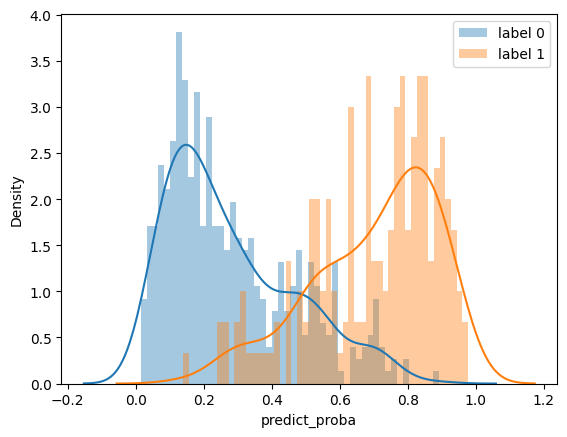

/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


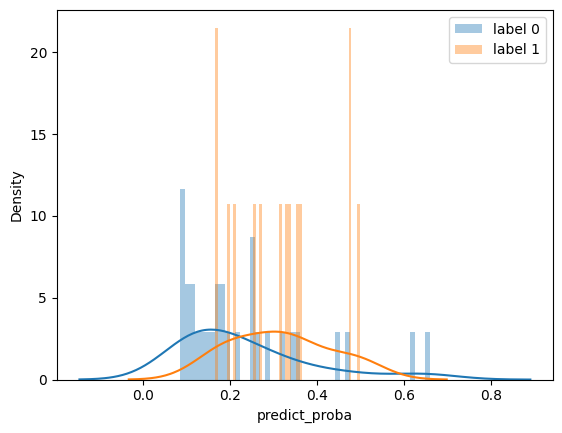

In [26]:
plot_hist(df.query('split == "train"'), 'label', 'predict_proba')
plot_hist(df.query('split == "val"'), 'label', 'predict_proba')

In [41]:
val_score = calc_metrics(df.query('split == "val"'), 'uuid_vacancy', 'label', 'predict_proba', 0.5)
display(val_score)

val_score = calc_metrics(df.query('split == "val"'), 'uuid_vacancy', 'label', 'predict_proba', 0.2)
display(val_score)
display(val_score.mean())

,roc_auc_score,f1_score,precision_score,recall_score
uuid_vacancy,,,,
4e2299c0-13fc-301d-8f3c-3ccfd0281ce6,0.777778,0.0,0.0,0.0
a5d0e1fd-7baa-3a6f-98f4-b908ac7fce43,0.466667,0.0,0.0,0.0
b2315867-73a2-3d43-acac-cbb92bd793b3,0.875000,0.0,0.0,0.0


,roc_auc_score,f1_score,precision_score,recall_score
uuid_vacancy,,,,
4e2299c0-13fc-301d-8f3c-3ccfd0281ce6,0.777778,0.533333,0.363636,1.000000
a5d0e1fd-7baa-3a6f-98f4-b908ac7fce43,0.466667,0.666667,0.555556,0.833333
b2315867-73a2-3d43-acac-cbb92bd793b3,0.875000,0.500000,0.500000,0.500000


roc_auc_score      0.706481
f1_score           0.566667
precision_score    0.473064
recall_score       0.777778
dtype: float64